### Read in Libraries

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR



### Read in the data

In [4]:
df = pd.read_csv('../data/final_dfs/combined_final.csv', index_col='date')

In [5]:
df.head()

,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
date,,,,,,,,
2011-01-01,1240.848016,304483.8981,670.712237,90516.91023,357.449324,70.651290,123213.38820,248086.36399
2011-01-02,1478.590690,320703.6726,667.009668,90462.21494,372.626928,10.255158,62531.39844,268971.64998
2011-01-03,1483.246127,296436.2237,741.426017,90472.37075,401.536782,15.155827,89515.57352,222285.00985
2011-01-04,1411.010006,322214.6377,683.281626,90312.68708,478.415477,5.278214,59542.48570,271747.93685
2011-01-05,1348.331266,308136.0801,623.145421,90280.19160,440.383112,22.997359,128920.84250,358001.80005


In [6]:
df['total'] = df.sum(axis=1)

In [7]:
df

,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas,total
date,,,,,,,,,
2011-01-01,1240.848016,304483.898100,670.712237,90516.910230,357.449324,70.651290,123213.388200,248086.363990,7.686402e+05
2011-01-02,1478.590690,320703.672600,667.009668,90462.214940,372.626928,10.255158,62531.398440,268971.649980,7.451974e+05
2011-01-03,1483.246127,296436.223700,741.426017,90472.370750,401.536782,15.155827,89515.573520,222285.009850,7.013505e+05
2011-01-04,1411.010006,322214.637700,683.281626,90312.687080,478.415477,5.278214,59542.485700,271747.936850,7.463957e+05
2011-01-05,1348.331266,308136.080100,623.145421,90280.191600,440.383112,22.997359,128920.842500,358001.800050,8.877738e+05
...,...,...,...,...,...,...,...,...,...
2020-12-27,635.255371,184407.678785,500.494667,122762.954790,13.731479,29820.239198,321323.147861,194637.587100,8.541011e+05
2020-12-28,591.302614,193621.421107,636.269588,122720.408975,-13.652177,19924.960198,350947.810220,216475.798107,9.049043e+05
2020-12-29,667.202987,144900.104532,643.995831,122664.769337,-26.962775,11594.382815,443182.060206,167954.504264,8.915801e+05


In [8]:
df.isnull().sum()

Biomass    181
Coal         0
Hydro        0
Nuclear      0
Other        0
Solar      173
Wind         0
NGas         0
total        0
dtype: int64

## VAR Time Series Models

In [1]:

# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat

In [12]:
# Initiating the class
deep_learner = DeepModelTS(
data = df,
Y_var = 'Wind',
lag = 30,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [13]:
model = deep_learner.LSTModel()


Epoch 1/10
13/13 [==============================] - 2s 80ms/step - loss: 9249972955.4286 - val_loss: 32760530944.0000
Epoch 2/10
13/13 [==============================] - 0s 38ms/step - loss: 5996880493.7143 - val_loss: 15770884096.0000
Epoch 3/10
13/13 [==============================] - 1s 40ms/step - loss: 5020377051.4286 - val_loss: 20000036864.0000
Epoch 4/10
13/13 [==============================] - 1s 39ms/step - loss: 4686558646.8571 - val_loss: 15709451264.0000
Epoch 5/10
13/13 [==============================] - 1s 38ms/step - loss: 4190404352.0000 - val_loss: 16825759744.0000
Epoch 6/10
13/13 [==============================] - 1s 40ms/step - loss: 4012878134.8571 - val_loss: 15764307968.0000
Epoch 7/10
13/13 [==============================] - 0s 38ms/step - loss: 3765843922.2857 - val_loss: 14528633856.0000
Epoch 8/10
13/13 [==============================] - 1s 39ms/step - loss: 3852308160.0000 - val_loss: 15023267840.0000
Epoch 9/10
13/13 [==============================] - 1s 3

In [14]:
# Defining the lag that we used for training of the model 
lag_model = 30
# Getting the last period
ts = df['Wind'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

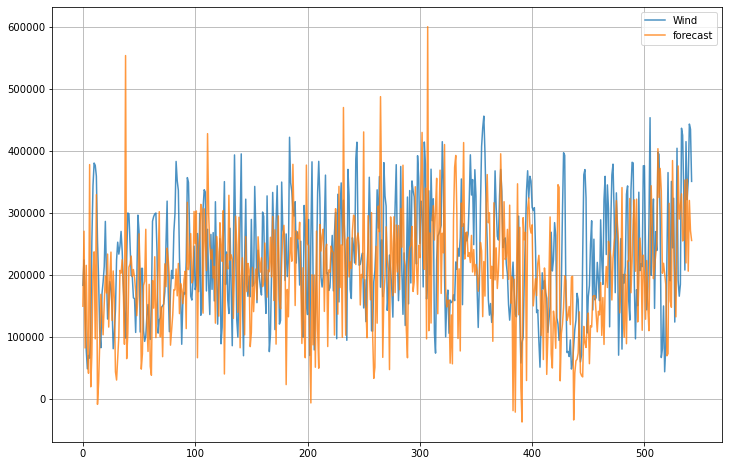

In [19]:
yhat = deep_learner.predict()

# Constructing the forecast dataframe
fc = df.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat

# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Wind', 'forecast']:
  plt.plot(
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )

plt.legend()
plt.grid()
plt.show()

In [21]:
# Creating the model using full data and forecasting n steps ahead
deep_learner = DeepModelTS(
data=df,
Y_var='Wind',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)
# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/10
15/15 [==============================] - 2s 64ms/step - loss: 15107083904.0000
Epoch 2/10
15/15 [==============================] - 1s 62ms/step - loss: 9349010784.0000
Epoch 3/10
15/15 [==============================] - 1s 62ms/step - loss: 8363738576.0000
Epoch 4/10
15/15 [==============================] - 1s 69ms/step - loss: 7905559312.0000 0s - loss: 7120863981.71
Epoch 5/10
15/15 [==============================] - 1s 64ms/step - loss: 6892873504.0000
Epoch 6/10
15/15 [==============================] - 1s 63ms/step - loss: 5936080352.0000
Epoch 7/10
15/15 [==============================] - 1s 83ms/step - loss: 5922794656.0000
Epoch 8/10
15/15 [==============================] - 1s 62ms/step - loss: 9084001456.0000
Epoch 9/10
15/15 [==============================] - 1s 64ms/step - loss: 9891059552.0000
Epoch 10/10
15/15 [==============================] - 1s 68ms/step - loss: 8758165600.0000


In [24]:
df

,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas,total
date,,,,,,,,,
2011-01-01,1240.848016,304483.898100,670.712237,90516.910230,357.449324,70.651290,123213.388200,248086.363990,7.686402e+05
2011-01-02,1478.590690,320703.672600,667.009668,90462.214940,372.626928,10.255158,62531.398440,268971.649980,7.451974e+05
2011-01-03,1483.246127,296436.223700,741.426017,90472.370750,401.536782,15.155827,89515.573520,222285.009850,7.013505e+05
2011-01-04,1411.010006,322214.637700,683.281626,90312.687080,478.415477,5.278214,59542.485700,271747.936850,7.463957e+05
2011-01-05,1348.331266,308136.080100,623.145421,90280.191600,440.383112,22.997359,128920.842500,358001.800050,8.877738e+05
...,...,...,...,...,...,...,...,...,...
2020-12-27,635.255371,184407.678785,500.494667,122762.954790,13.731479,29820.239198,321323.147861,194637.587100,8.541011e+05
2020-12-28,591.302614,193621.421107,636.269588,122720.408975,-13.652177,19924.960198,350947.810220,216475.798107,9.049043e+05
2020-12-29,667.202987,144900.104532,643.995831,122664.769337,-26.962775,11594.382815,443182.060206,167954.504264,8.915801e+05


In [23]:
# Code written by Joseph Nelson.
# Improved by Hovanes Gasparian

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

## Dickey-Fuller Tests on each Source

### Total

In [35]:
interpret_dftest(adfuller(df['total']))

Test Statistic    -3.656148
p-value            0.004774
Lag Used          29.000000
dtype: float64

In [81]:
interpret_dftest(adfuller(df['total'].diff(1).dropna()))

Test Statistic   -1.692813e+01
p-value           9.823692e-30
Lag Used          2.800000e+01
dtype: float64

In [82]:
df['first_diff_total'] = df['total'].diff(1)

### Biomass

In [24]:
interpret_dftest(adfuller(df['Biomass']))

Test Statistic   -7.435146e+00
p-value           6.211646e-11
Lag Used          2.400000e+01
dtype: float64

### Coal

In [25]:
interpret_dftest(adfuller(df['Coal']))

Test Statistic    -2.877402
p-value            0.048040
Lag Used          29.000000
dtype: float64

In [83]:
interpret_dftest(adfuller(df['Coal'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [85]:
df['first_diff_coal'] = df['Coal'].diff(1)

### Gas

In [26]:
interpret_dftest(adfuller(df['NGas']))

Test Statistic    -4.165856
p-value            0.000752
Lag Used          24.000000
dtype: float64

In [79]:
interpret_dftest(adfuller(df['NGas'].diff(1).dropna()))

Test Statistic   -1.802050e+01
p-value           2.696237e-30
Lag Used          2.400000e+01
dtype: float64

In [87]:
df['first_diff_ngas'] = df['NGas'].diff(1)

### Hydro

In [28]:
interpret_dftest(adfuller(df['Hydro']))

Test Statistic    -4.377611
p-value            0.000325
Lag Used          30.000000
dtype: float64

### Nuclear

In [14]:
interpret_dftest(adfuller(df['Nuclear']))

Test Statistic   -2.949252
p-value           0.039913
Lag Used          3.000000
dtype: float64

In [88]:
interpret_dftest(adfuller(df['Nuclear'].diff(1).dropna()))

Test Statistic   -1.480475e+01
p-value           2.073387e-27
Lag Used          3.000000e+01
dtype: float64

In [89]:
df['first_diff_nuclear'] = df['Nuclear'].diff(1)

### Other

In [29]:
interpret_dftest(adfuller(df['Other']))

Test Statistic    -4.578738
p-value            0.000141
Lag Used          30.000000
dtype: float64

### Wind

In [30]:
interpret_dftest(adfuller(df['Wind']))

Test Statistic    -2.681855
p-value            0.077231
Lag Used          28.000000
dtype: float64

In [31]:
# Differenced 
interpret_dftest(adfuller(df['Wind'].diff(1).dropna()))

Test Statistic   -1.804267e+01
p-value           2.654696e-30
Lag Used          3.000000e+01
dtype: float64

#### Because we see a much lower p-value with the differenced data, let's save this column to our dataframe to use in our model

In [37]:
df['first_diff_wind'] = df['Wind'].diff(1)

### Solar

In [32]:
interpret_dftest(adfuller(df['Solar']))

Test Statistic    -1.083391
p-value            0.721650
Lag Used          28.000000
dtype: float64

In [75]:
interpret_dftest(adfuller(df['Solar'].diff(1).dropna()))

Test Statistic   -1.471495e+01
p-value           2.809432e-27
Lag Used          3.000000e+01
dtype: float64

In [76]:
df['first_diff_solar'] = df['Solar'].diff(1)

### Plot ACF & PACF

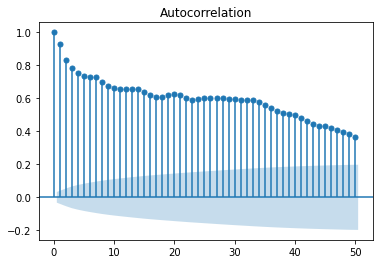

In [33]:
# plot the total electricity acf
plot_acf(df['total'], lags = 50);

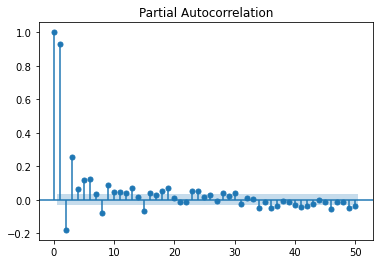

In [36]:
# plot the total electricity pacf
plot_pacf(df['total'], lags = 50);

### Modeling

In [91]:
# Subset our data
model_df = df[['first_diff_total', 'first_diff_ngas', 'first_diff_coal', 'first_diff_wind', 'first_diff_solar', 'first_diff_nuclear']].copy()

# Let's drop rows containing missing data
model_df.dropna(inplace = True)

In [92]:
train, test = train_test_split(model_df,
                              test_size = 0.10, 
                              shuffle=False)

In [93]:
train.head()

,first_diff_total,first_diff_ngas,first_diff_coal,first_diff_wind,first_diff_solar,first_diff_nuclear
date,,,,,,
2011-01-02,-23442.802983,20885.28599,16219.7745,-60681.98976,-60.396132,-54.69529
2011-01-03,-43846.875831,-46686.64013,-24267.4489,26984.17508,4.900669,10.15581
2011-01-04,45045.190080,49462.92700,25778.4140,-29973.08782,-9.877613,-159.68367
2011-01-05,141378.038755,86253.86320,-14078.5576,69378.35680,17.719145,-32.49548
2011-01-06,110739.930548,129772.98138,68316.4110,-87654.82550,43.006927,55.87253


In [94]:
var_model = VAR(train)

/Users/andrewroberts/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [95]:
ts_model = var_model.fit(maxlags=5, ic='aic')

In [96]:
# What is the order of our autogressive model?
ts_model.k_ar

5

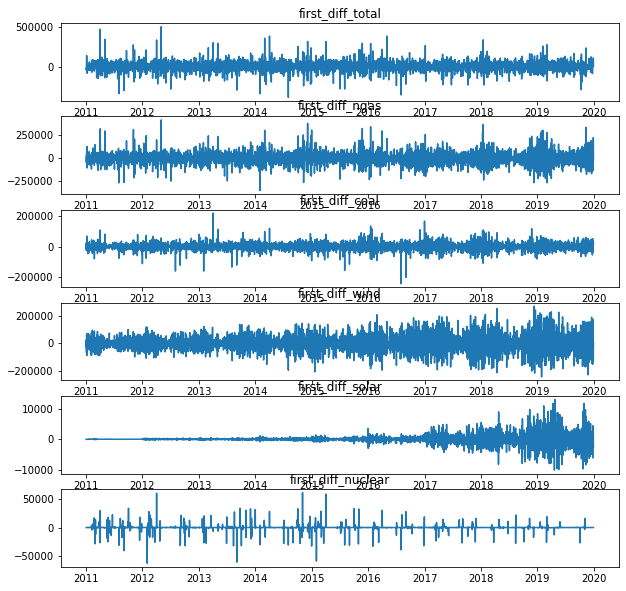

In [97]:
ts_model.plot();

<Figure size 1440x1440 with 0 Axes>

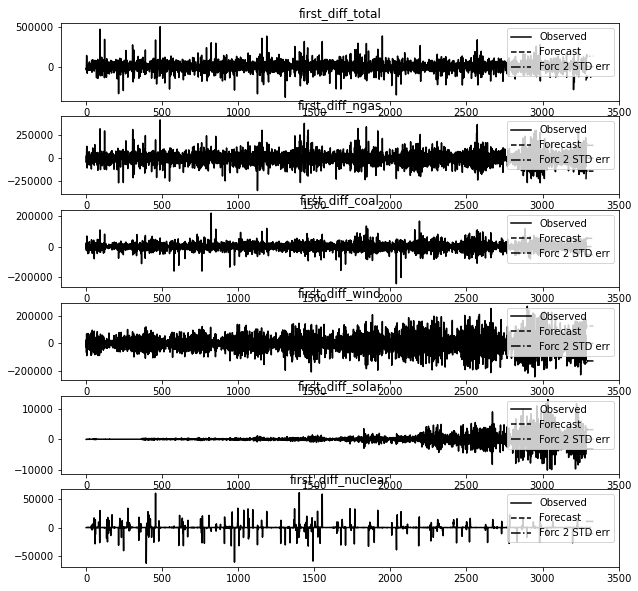

In [98]:
# plot the forecast looking 5 steps ahead
plt.figure(figsize=(20,20))
ts_model.plot_forecast(50);

### Evaluate our models (and forecasts, in possible)

In [99]:
forecast = ts_model.forecast(train.values, len(test))

In [100]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the first_diff_total data is: 3646963703.8777
The test MSE on the first_diff_ngas data is: 7318147209.5251
The test MSE on the first_diff_coal data is: 481133679.7592
The test MSE on the first_diff_wind data is: 9772181147.9876
The test MSE on the first_diff_solar data is: 54294441.1495
The test MSE on the first_diff_nuclear data is: 9935431.4502


In [101]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the first_diff_total data is: 60390.0961
The test RMSE on the first_diff_ngas data is: 85546.17
The test RMSE on the first_diff_coal data is: 21934.7596
The test RMSE on the first_diff_wind data is: 98854.3431
The test RMSE on the first_diff_solar data is: 7368.4762
The test RMSE on the first_diff_nuclear data is: 3152.0519


### Evaluate our models (and forecasts, in possible)

In [69]:
forecast = ts_model.forecast(train.values, len(test))

In [70]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the total data is: 29577405684.7134
The test MSE on the NGas data is: 23416882833.6194
The test MSE on the Coal data is: 6518154937.4332
The test MSE on the first_diff_wind data is: 9770433458.8709
The test MSE on the Solar data is: 422323163.5973
The test MSE on the Nuclear data is: 182154113.8146


In [71]:
# Loop through columns and get RMSE for each
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i], squared=False), 4)}')

The test RMSE on the total data is: 171980.8294
The test RMSE on the NGas data is: 153025.7587
The test RMSE on the Coal data is: 80735.0911
The test RMSE on the first_diff_wind data is: 98845.503
The test RMSE on the Solar data is: 20550.5028
The test RMSE on the Nuclear data is: 13496.4482


In [73]:
from autots import AutoTS

